# Определение стоимости автомобилей
Для сервиса по продаже автомобилей необходимо разработать модель, которая по техническим характеристикам и комплектации автомобиля предскажет его стоимость. 

Для этого предоставлен датасет с характеристиками автомобилей, комплектацией и ценой.

Важные параметры:
- качество предсказания;
- скорость предсказания;
- время обучения.

<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Дополнительные-исследования" data-toc-modified-id="Дополнительные-исследования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Дополнительные исследования</a></span><ul class="toc-item"><li><span><a href="#ordinal-категоризация" data-toc-modified-id="ordinal-категоризация-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>ordinal-категоризация</a></span></li><li><span><a href="#Добавление-географии-автомобилей" data-toc-modified-id="Добавление-географии-автомобилей-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Добавление географии автомобилей</a></span></li><li><span><a href="#Ограничение-года-выпуска-автомобилей" data-toc-modified-id="Ограничение-года-выпуска-автомобилей-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Ограничение года выпуска автомобилей</a></span></li><li><span><a href="#Удаление-всех-пропусков-и-артефактов" data-toc-modified-id="Удаление-всех-пропусков-и-артефактов-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Удаление всех пропусков и артефактов</a></span></li><li><span><a href="#Важность-факторов" data-toc-modified-id="Важность-факторов-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Важность факторов</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ моделей</a></span></li></ul></div>

## Подготовка данных

Импортируем необходимые для исследования библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer


from lightgbm import LGBMRegressor
from lightgbm import plot_importance

Загрузим предоставленный датасет. Выведем информацию о нем, и посмотрим первые строки.

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак:**
- Price — цена (евро)

In [2]:
data = pd.read_csv("/datasets/autos.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


В датасете присутствую пропуски. Посмотрим на их количество.

In [3]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Для дальнейшего удобства переведем название столбцов в нижний регистр.

In [4]:
data.columns = [x.lower() for x in data.columns]

Самый критичный параметр из пропущенных - марка автомобиля. Просмотрим строки с пропущенной маркой.

In [5]:
data[data['model'].isna()].head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
59,2016-03-29 15:48:15,1,suv,1994,manual,286,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
81,2016-04-03 12:56:45,350,small,1997,manual,54,NaN,150000,3,NaN,fiat,yes,2016-04-03 00:00:00,0,45665,2016-04-05 11:47:13
115,2016-03-20 18:53:27,0,small,1999,NaN,0,NaN,5000,0,petrol,volkswagen,NaN,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27 00:00:00,0,38709,2016-04-05 20:17:31


Можно заметить, что в выборке присутствуют автомобили ценой 0 и 1 евро, а также значение 0 в столбце `power`.

Просмотрим автомобили одного бренда с пропущенной маркой.

In [6]:
data[(data['model'].isna()) & (data['brand']=='audi')].head(7)

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
135,2016-03-27 20:51:23,1450,sedan,1992,manual,136,NaN,150000,0,NaN,audi,no,2016-03-27 00:00:00,0,38709,2016-04-05 20:17:31
273,2016-03-29 23:38:02,1500,coupe,1994,manual,116,NaN,150000,8,NaN,audi,no,2016-03-29 00:00:00,0,32791,2016-04-06 20:16:34
478,2016-03-24 17:49:19,0,NaN,2000,manual,0,NaN,150000,0,NaN,audi,yes,2016-03-24 00:00:00,0,72514,2016-03-29 03:45:06
644,2016-03-27 22:52:02,2200,sedan,1995,auto,299,NaN,150000,5,NaN,audi,yes,2016-03-27 00:00:00,0,74182,2016-04-05 23:47:17
1172,2016-03-17 09:38:12,4600,NaN,2017,manual,131,NaN,150000,6,NaN,audi,NaN,2016-03-17 00:00:00,0,45529,2016-04-06 07:44:21
1851,2016-04-01 10:50:32,7500,wagon,2005,manual,179,NaN,150000,5,gasoline,audi,no,2016-04-01 00:00:00,0,91126,2016-04-07 07:46:03


Никакой логики в пропущенной марке не наблюдается.

Можно было бы воспользоваться машинным обучением, и по бренду, типу кузова и году выпуска предсказать модель автомобиля. Но вместо этого просто отбросим все строки с неизвестной маркой.

In [7]:
data = data.dropna(subset=['model'], axis=0)
data.isna().sum()

datecrawled              0
price                    0
vehicletype          30662
registrationyear         0
gearbox              15702
power                    0
model                    0
kilometer                0
registrationmonth        0
fueltype             25732
brand                    0
notrepaired          62100
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

Количество пропусков в других признаках уменьшилось.

Теперь проанализируем типы коробки передач. Для этого составим сводную таблицу.

In [8]:
(data.fillna('неизвестно')
    .pivot_table(index=['brand','model'], columns = ['gearbox'], values = 'price', aggfunc='count')
    .sort_values('неизвестно', ascending = False).head(10))

,gearbox,auto,manual,неизвестно
brand,model,,,
volkswagen,golf,3005.0,24752.0,1475.0
smart,fortwo,3175.0,376.0,786.0
opel,corsa,608.0,11183.0,779.0
volkswagen,polo,474.0,11860.0,732.0
bmw,3er,3780.0,15306.0,675.0
opel,astra,820.0,9537.0,452.0
volkswagen,passat,2223.0,7478.0,445.0
renault,twingo,187.0,4342.0,424.0
audi,a4,2321.0,7193.0,386.0


Из сводной таблицы видно, что в основном у каждой модели авто преобладает определенный тип коробки передач. Все неизвестные просто отнесем к самому популярному виду.

Для начала определим самый популярный тип трансмиссии на автомобиле конкретной марки.

In [9]:
gearbox = (data.fillna('Неизвестно')
    .pivot_table(index=['brand','model'], columns = ['gearbox'], values = 'price', aggfunc='count')
    .sort_values('Неизвестно', ascending = False).reset_index())

def ger(string):
    if string['auto'] > string['manual']:
        return 'auto'
    else:
        return 'manual'
gearbox['prevailing_gearbox'] = gearbox.apply(ger, axis = 1)
gearbox.head()

gearbox,brand,model,auto,manual,Неизвестно,prevailing_gearbox
0,volkswagen,golf,3005.0,24752.0,1475.0,manual
1,smart,fortwo,3175.0,376.0,786.0,auto
2,opel,corsa,608.0,11183.0,779.0,manual
3,volkswagen,polo,474.0,11860.0,732.0,manual
4,bmw,3er,3780.0,15306.0,675.0,manual


Все работает правильно. Теперь определим словарь значений и заполним им пропуски в таблице `data`.

In [10]:
dict_gearbox = gearbox.set_index(['brand', 'model'])['prevailing_gearbox'].to_dict()

Ключем к словарю является множество:

In [11]:
dict_gearbox[('volkswagen', 'golf')]

'manual'

Напишем функцию для установки значений из словаря и применим ее.

In [12]:
%%time
def set_gearbox(string):
    if string['gearbox']!=string['gearbox']: #проверка на Nan
        try:
            return dict_gearbox[(string['brand'], string['model'])]
        except:
            return np.nan
    else:
        return string['gearbox']
data['gearbox'] = data.apply(set_gearbox ,axis=1)
data.isna().sum()

CPU times: user 11 s, sys: 75.3 ms, total: 11 s
Wall time: 11.4 s


datecrawled              0
price                    0
vehicletype          30662
registrationyear         0
gearbox                  0
power                    0
model                    0
kilometer                0
registrationmonth        0
fueltype             25732
brand                    0
notrepaired          62100
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

Пропуски из признака `gearbox` исчезли. Аналогичным образом избавимся от пропусков в признаках `vehicletype` и `fueltype`.

Начнем с `fueltype`:

In [13]:
fueltype = (data.fillna('Неизвестно')
    .pivot_table(index=['brand','model'], columns = ['fueltype'], values = 'price', aggfunc='count')
    .sort_values('Неизвестно', ascending = False).reset_index())
fueltype['prevailing_fueltype'] = fueltype.loc[:,"cng":"petrol"].idxmax(axis="columns")
dict_fueltype = fueltype.set_index(['brand', 'model'])['prevailing_fueltype'].to_dict()
fueltype.head()

fueltype,brand,model,cng,electric,gasoline,hybrid,lpg,other,petrol,Неизвестно,prevailing_fueltype
0,volkswagen,golf,23.0,3.0,7096.0,1.0,172.0,8.0,19499.0,2430.0,petrol
1,bmw,3er,5.0,1.0,4888.0,NaN,335.0,3.0,13199.0,1330.0,petrol
2,volkswagen,polo,4.0,NaN,1269.0,1.0,48.0,1.0,10418.0,1325.0,petrol
3,opel,corsa,5.0,NaN,666.0,2.0,63.0,4.0,10514.0,1316.0,petrol
4,opel,astra,17.0,1.0,1847.0,2.0,168.0,5.0,7746.0,1023.0,petrol


In [14]:
%%time
def set_fueltype(string):
    if string['fueltype']!=string['fueltype']: #проверка на Nan
        try:
            return dict_fueltype[(string['brand'], string['model'])]
        except:
            return np.nan
    else:
        return string['fueltype']
data['fueltype'] = data.apply(set_fueltype ,axis=1)
data.isna().sum()

CPU times: user 11.4 s, sys: 106 ms, total: 11.5 s
Wall time: 11.9 s


datecrawled              0
price                    0
vehicletype          30662
registrationyear         0
gearbox                  0
power                    0
model                    0
kilometer                0
registrationmonth        0
fueltype                 0
brand                    0
notrepaired          62100
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

Продолжим с `vehicletype`:

In [15]:
vehicletype = (data.fillna('Неизвестно')
    .pivot_table(index=['brand','model'], columns = ['vehicletype'], values = 'price', aggfunc='count')
    .sort_values('Неизвестно', ascending = False).reset_index())
vehicletype

vehicletype,brand,model,bus,convertible,coupe,other,sedan,small,suv,wagon,Неизвестно
0,volkswagen,golf,760.0,1962.0,429.0,185.0,14744.0,3911.0,25.0,3181.0,4035.0
1,volkswagen,polo,2.0,3.0,265.0,23.0,612.0,10267.0,2.0,292.0,1600.0
2,opel,corsa,3.0,8.0,49.0,18.0,402.0,10499.0,1.0,14.0,1576.0
3,bmw,3er,2.0,2200.0,3107.0,197.0,8087.0,269.0,3.0,4584.0,1312.0
4,opel,astra,1.0,1047.0,932.0,76.0,3769.0,483.0,1.0,3313.0,1187.0
...,...,...,...,...,...,...,...,...,...,...,...
292,peugeot,5_reihe,41.0,3.0,3.0,1.0,23.0,NaN,NaN,42.0,NaN
293,rover,defender,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
294,rover,discovery,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN
295,rover,freelander,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN


In [16]:
vehicletype = (data.fillna('Неизвестно')
    .pivot_table(index=['brand','model'], columns = ['vehicletype'], values = 'price', aggfunc='count')
    .sort_values('Неизвестно', ascending = False).reset_index())
vehicletype['prevailing_vehicletype'] = vehicletype.loc[:,"bus":"wagon"].idxmax(axis="columns")
dict_vehicletype = vehicletype.set_index(['brand', 'model'])['prevailing_vehicletype'].to_dict()
vehicletype.head()

vehicletype,brand,model,bus,convertible,coupe,other,sedan,small,suv,wagon,Неизвестно,prevailing_vehicletype
0,volkswagen,golf,760.0,1962.0,429.0,185.0,14744.0,3911.0,25.0,3181.0,4035.0,sedan
1,volkswagen,polo,2.0,3.0,265.0,23.0,612.0,10267.0,2.0,292.0,1600.0,small
2,opel,corsa,3.0,8.0,49.0,18.0,402.0,10499.0,1.0,14.0,1576.0,small
3,bmw,3er,2.0,2200.0,3107.0,197.0,8087.0,269.0,3.0,4584.0,1312.0,sedan
4,opel,astra,1.0,1047.0,932.0,76.0,3769.0,483.0,1.0,3313.0,1187.0,sedan


In [17]:
%%time
def set_vehicletype(string):
    if string['vehicletype']!=string['vehicletype']: #проверка на Nan
        try:
            return dict_vehicletype[(string['brand'], string['model'])]
        except:
            return np.nan
    else:
        return string['vehicletype']
data['vehicletype'] = data.apply(set_vehicletype ,axis=1)
data.isna().sum()

CPU times: user 11.2 s, sys: 82.7 ms, total: 11.3 s
Wall time: 11.5 s


datecrawled              0
price                    0
vehicletype              0
registrationyear         0
gearbox                  0
power                    0
model                    0
kilometer                0
registrationmonth        0
fueltype                 0
brand                    0
notrepaired          62100
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

Просмотрим на уникальные значения в столбце `notrepaired`.

In [18]:
data['notrepaired'].value_counts(dropna=False)

no     238855
NaN     62100
yes     33709
Name: notrepaired, dtype: int64

Есть и "да" и "нет". Пропуск не означает отсутствие или наличие ремонта.
Посмотрим на признаки с пропусками.

In [19]:
data[data['notrepaired'].isna()].head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,petrol,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
12,2016-03-15 22:49:09,999,wagon,1995,manual,115,passat,150000,11,petrol,volkswagen,NaN,2016-03-15 00:00:00,0,37269,2016-04-01 13:16:16


Ремонт не указан ни у машины 2014 года, ни у 1995го. Неизвестные значения заполним следующим образом: найдем максимальный год регистрации машины, отнимем от него 5. Выше получившейся границы проставим, что ремонта небыло, ниже - что ремонт был. Допустим, что за 5 лет эксплутации машину необходимо хотя бы раз отремонтировать.

Найдем максимальное значение года выпуска.

In [20]:
data['registrationyear'].max()

9999

Очень плохо. Построим "Ящик с усами", что бы посмотреть на эту аномалию.

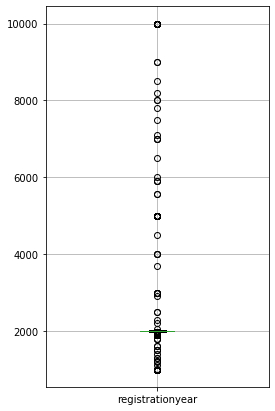

In [21]:
data.boxplot(column=['registrationyear'], figsize =(4,7), grid = True);

Отбросим все значения выше 2022 года, и еще раз взглянем на график.

In [22]:
print("До удаления, строк -", data.shape[0])
data = data[data['registrationyear']<2017]
print("После удаления, строк -", data.shape[0])

До удаления, строк - 334664
После удаления, строк - 322181


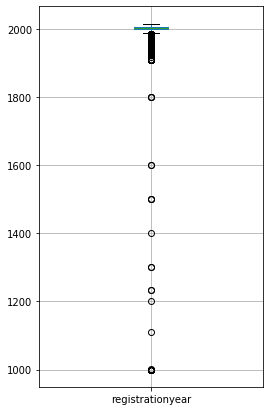

In [23]:
data.boxplot(column=['registrationyear'], figsize =(4,7), grid = True);

Удалим все деревянные повозки из датасета. Оставим только постреволюционные автомобили.

In [24]:
print("До удаления, строк -", data.shape[0])
data = data[data['registrationyear']>=1960]
print("После удаления, строк -", data.shape[0])

До удаления, строк - 322181
После удаления, строк - 321954


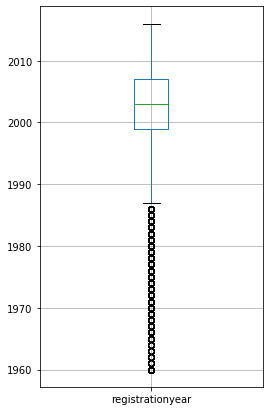

In [25]:
data.boxplot(column=['registrationyear'], figsize =(4,7), grid = True);

Теперь реализуем идею с заменой пропусков в столбце `registrationyear`.

In [26]:
max_registrationyear = data['registrationyear'].max()
def set_notrepaired(string):
    registrationyear = string['registrationyear']
    if registrationyear != registrationyear: #проверка на Nan
        if  registrationyear > max_registrationyear - 5:
            return 'yes'
        else:
            return 'no'
    else:
        return string['notrepaired']

In [27]:
%%time
data['notrepaired'] = data.apply(set_notrepaired, axis =1)
data.isna().sum()

CPU times: user 7.83 s, sys: 91.5 ms, total: 7.92 s
Wall time: 8.15 s


datecrawled              0
price                    0
vehicletype              0
registrationyear         0
gearbox                  0
power                    0
model                    0
kilometer                0
registrationmonth        0
fueltype                 0
brand                    0
notrepaired          56649
datecreated              0
numberofpictures         0
postalcode               0
lastseen                 0
dtype: int64

In [28]:
data

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23
354364,2016-03-21 09:50:58,0,sedan,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Теперь, когда пропусков больше нет, проверим датасет на остальные аномалии. Начнем с мощности машин.

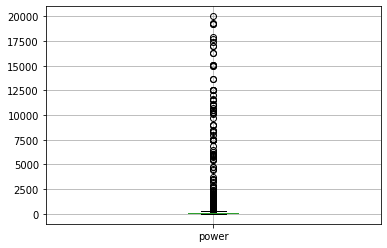

In [29]:
data.boxplot(column=['power']);

[Тут](https://rating-avto.ru/raznoe/samyie-moshhnyie-avtomobilnyie-dvigateli.html) сказано, что максимальная мощность автомобильного двигателя 797 лошадинных сил у автомобиля Dodge Challenger. Это и возьмем за верхнюю границу.

До удаления, строк - 321954
После удаления, строк - 321683


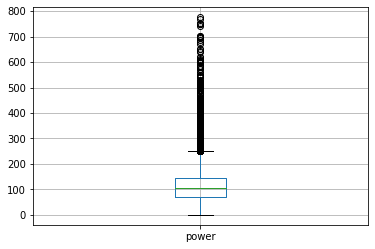

In [30]:
print("До удаления, строк -", data.shape[0])
data = data[data['power']<798]
print("После удаления, строк -", data.shape[0])
data.boxplot(column=['power']);

Посмотрим строки и их количество у автомобилей с 0 лошадинными силами.

In [31]:
data[data['power'] <10]

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
32,2016-03-15 20:59:01,245,sedan,1994,manual,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,bus,2016,manual,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
40,2016-03-26 22:06:17,0,small,1990,manual,0,corsa,150000,1,petrol,opel,NaN,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
54,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,gasoline,opel,no,2016-03-17 00:00:00,0,88433,2016-04-04 04:17:32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354336,2016-03-05 18:57:45,3299,suv,2005,auto,0,outlander,150000,4,petrol,mitsubishi,NaN,2016-03-05 00:00:00,0,17034,2016-03-06 04:17:37
354346,2016-03-07 17:06:35,2600,sedan,2005,auto,0,c_klasse,150000,9,petrol,mercedes_benz,NaN,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02 00:00:00,0,81825,2016-04-06 20:47:12
354363,2016-03-27 20:36:20,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,2016-03-27 00:00:00,0,26624,2016-03-29 10:17:23


Достаточно много. Изучим распределение мощности у конкретной марки автомобиля.

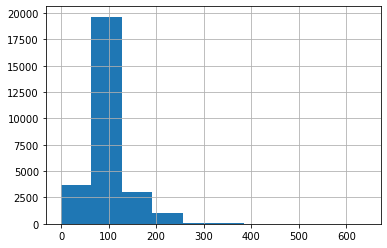

In [32]:
data[(data['brand']=="volkswagen") & (data['model']=="golf")]['power'].hist()

Для автомобилей с мощностью менее 10 лошадинных сил заменим значение на среднее.

In [33]:
power = (data[data['power']>10]
    .pivot_table(index=['brand','model'], values = ['power'], aggfunc='mean')).reset_index()
power.head()

,brand,model,power
0,alfa_romeo,145,111.972222
1,alfa_romeo,147,120.656746
2,alfa_romeo,156,150.904085
3,alfa_romeo,159,173.196970
4,alfa_romeo,other,148.424947


In [34]:
%%time
dict_power = power.set_index(['brand', 'model'])['power'].to_dict()
def set_power(string):
    if string['power']<=10:
        try:
            return dict_power[(string['brand'], string['model'])]
        except:
            return np.nan
    else:
        return string['power']
data['power'] = data.apply(set_power ,axis=1)
data = data.dropna() #2 строчки остунутся без значения, сразу удалим их

CPU times: user 8.08 s, sys: 132 ms, total: 8.21 s
Wall time: 8.23 s


Оценим качество целевого признака.

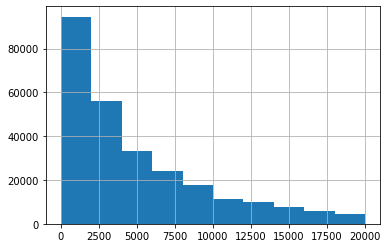

In [35]:
data['price'].hist();

Распределение нормальное. Просмотрим автомобили с очень низкими ценами, включая 0.

In [36]:
print('Цена менее 50 евро -', data[data['price']<100].count()['datecrawled'])
print('Цена 0 евро -', data[data['price']==50].count()['datecrawled'])

Цена менее 50 евро - 5349
Цена 0 евро - 137


За 50 евро автомобиль выгоднее сдать на металлолом или запчасти. Автомобили с ценой 0 евро не подходят для обучения модели. Удалим критически дешевые и бесплатные автомобили.

In [37]:
data = data[data['price']>50]

На этом предобработку данных считаю законченной.

## Обучение моделей

Разобьем данные по признакам.

In [38]:
features = data.drop(['datecrawled','price','registrationmonth', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen'] ,axis=1)
features_dummies = pd.get_dummies(features, drop_first=True)
target = data['price']

Разобьем данные на тестовую и обучающую выборки.

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    features_dummies, target, test_size=.25, random_state=12345)

Найдем RMSE для предсказания средним по обучающей выборке.

In [40]:
%%time
mean_price = np.full(X_test.shape[0], y_train.mean())
mean_RMSE = mean_squared_error(y_test, np.full(X_test.shape[0], mean_price))**.5
mean_RMSE

CPU times: user 3.35 ms, sys: 0 ns, total: 3.35 ms
Wall time: 2.19 ms


4668.655762292769

Значение достаточно большое. Но зато есть, с чем сравнить. Обучим линейную регрессию.

In [41]:
%%time
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
model_linear_RMSE = mean_squared_error(y_test, model_linear.predict(X_test))**.5
model_linear_RMSE

CPU times: user 14.9 s, sys: 4.12 s, total: 19 s
Wall time: 19 s


2594.9780013810127

In [42]:
%%time
#Посчитаем время предсказания
model_linear.predict(X_test)

CPU times: user 96.2 ms, sys: 65.5 ms, total: 162 ms
Wall time: 138 ms


array([ 5065.40880541,  6341.00939321, -2072.87357381, ...,
         449.21802282,  2738.95471565,  4081.51582851])

Значение получилось намного лучше, чем заполнение средним, но все равно достаточно большим. Обучим случайный лес.

In [43]:
%%time
parametrs = { 'n_estimators': range (70, 71, 10),#значения зафиксированны для ускорения
              'max_depth': range (11, 12, 2)}
clf = RandomForestRegressor(random_state=12345)
grid = GridSearchCV(clf, parametrs, cv=2, scoring = 'neg_mean_squared_error')
grid.fit(features_dummies, target)
forest_model = grid.best_estimator_
forest_score = grid.best_score_
print(grid.best_params_)
"Лучший результат,",abs(forest_score)**.5

{'max_depth': 11, 'n_estimators': 70}
CPU times: user 8min 10s, sys: 842 ms, total: 8min 11s
Wall time: 8min 18s


('Лучший результат,', 1833.3583883223703)

In [44]:
%%time
#Посчитаем время предсказания
forest_model.predict(X_test)

CPU times: user 592 ms, sys: 64.1 ms, total: 656 ms
Wall time: 666 ms


array([3356.88283438, 5703.88741068,  608.50523104, ..., 1307.02471043,
       2706.35945921, 3177.72070878])

Обучим градиентную модель из библиотеки LightGBM.

In [45]:
%%time
parametrs = { 'n_estimators': range (80, 101, 10),
                  'max_depth': range (9, 13, 2)}
def LightGBM(features_1, target_1, parametrs=parametrs):
    clf = LGBMRegressor(random_state=12345)
    grid = GridSearchCV(clf, parametrs, cv=2, scoring = 'neg_mean_squared_error')
    grid.fit(features_1, target_1)
    boost_model = grid.best_estimator_
    boost_score = grid.best_score_
    print(grid.best_params_)
    print("Лучший результат,",abs(boost_score)**.5)
    return boost_model, boost_score
boost_model, boost_score = LightGBM(features_dummies, target)

{'max_depth': 11, 'n_estimators': 100}
Лучший результат, 1683.634481150884
CPU times: user 2min 6s, sys: 5.49 s, total: 2min 11s
Wall time: 2min 13s


In [46]:
%%time
#Посчитаем время предсказания
boost_model.predict(X_test)

CPU times: user 910 ms, sys: 80.5 ms, total: 990 ms
Wall time: 995 ms


array([3387.64599252, 6176.83530299,  343.53911637, ..., 1357.21065594,
       2583.08196102, 3014.96243058])

Результаты обучения занесем в датафрейм. Время обучения сведем к 1й итерации (время обучения на 1х параметрах), что бы разные модели можно было сравнить.

In [47]:
result = pd.DataFrame({'RMSE':[round(mean_RMSE),round(model_linear_RMSE),round(abs(forest_score)**.5),round(abs(boost_score)**.5)],
              'Время 1й итерации, секунд':[0, 24.9,574/2,123/12],
                'Время предсказания, секунд':[0,0.13,0.7,1.18]},
             index =['Заполнение средним','Линейная регрессия', 'Случайный лес', 'LightGBM'])

## Дополнительные исследования
Тут сделаю дополнительные пункты по улучшению предсказаний. Для предсказаний буду использовать только `LightGBM`, т.к. он и работает быстрее, и предсказывает точнее.
### ordinal-категоризация

Применим технику кодирования категориальных признаков Ordinal Encoding.

In [48]:
features = data.drop(['datecrawled','price','registrationmonth', 'datecreated', 'numberofpictures','postalcode', 'lastseen'] ,axis=1)
target = data['price']
cat_features = ['vehicletype','gearbox','model','fueltype','brand','notrepaired']
encoder = OrdinalEncoder() 
encoder.fit(features[cat_features])
features[cat_features] = encoder.transform(features[cat_features])
features.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
3,5.0,2001,1.0,75.0,116.0,150000,6.0,37.0,0.0
4,5.0,2008,1.0,69.0,101.0,90000,2.0,31.0,0.0
5,4.0,1995,1.0,102.0,11.0,150000,6.0,2.0,1.0
6,1.0,2004,1.0,109.0,8.0,150000,6.0,25.0,0.0
10,4.0,2004,1.0,105.0,10.0,150000,6.0,19.0,0.0


In [49]:
boost_model, _ = LightGBM(features, target)

{'max_depth': 11, 'n_estimators': 100}
Лучший результат, 1690.3583154120063


Вывод: результат ожидаемо не изменился, т.к. мы только поменяли кодирование.

### Добавление географии автомобилей
Добавим первую цифру из почтового индекса в признаки автомобилей.

In [50]:
features['postal_code'] = data['postalcode'].astype('str').str[0].astype('int')
features.head()

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired,postal_code
3,5.0,2001,1.0,75.0,116.0,150000,6.0,37.0,0.0,9
4,5.0,2008,1.0,69.0,101.0,90000,2.0,31.0,0.0,6
5,4.0,1995,1.0,102.0,11.0,150000,6.0,2.0,1.0,3
6,1.0,2004,1.0,109.0,8.0,150000,6.0,25.0,0.0,6
10,4.0,2004,1.0,105.0,10.0,150000,6.0,19.0,0.0,9


In [51]:
_, _ = LightGBM(features, target)

{'max_depth': 11, 'n_estimators': 100}
Лучший результат, 1689.661750001265


Вывод: География автомобилей никак не повлияла на результат предсказаний.

### Ограничение года выпуска автомобилей

Ограничим год выпуска автомобилей 2000. Проверим, как это скажется на точности предсказаний.

In [52]:
data_modern = data[data['registrationyear']>=2000]
features = data_modern.drop(['datecrawled','price','registrationmonth', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen'] ,axis=1)
target = data_modern['price']
features[cat_features] = encoder.transform(features[cat_features])
_, _ = LightGBM(features, target)

{'max_depth': 11, 'n_estimators': 100}
Лучший результат, 1721.7874758179487


Вывод: Стало незначительно хуже.

### Удаление всех пропусков и артефактов
Предобработаемых данные, удалив все пропуски.

In [53]:
data_clear = pd.read_csv("/datasets/autos.csv")
data_clear.columns = [x.lower() for x in data_clear.columns]
data_clear = data_clear.dropna()
data_clear = data_clear[(data_clear['power']<=798) & (data_clear['power']>20)]
data_clear = data_clear[(data_clear['registrationyear']<=2017) & (data_clear['registrationyear']>1960)]
data_clear = data_clear[data_clear['price']>50]
data_clear.shape[0]

232552

Обучим модель.

In [54]:
parametrs = { 'n_estimators': range (100, 131, 10),
                  'max_depth': range (9, 13, 2)}
features = data_clear.drop(['datecrawled','price','registrationmonth', 'datecreated', 'numberofpictures', 'postalcode', 'lastseen'] ,axis=1)
target = data_clear['price']
features[cat_features] = encoder.transform(features[cat_features])
_, _ = LightGBM(features, target)

{'max_depth': 11, 'n_estimators': 100}
Лучший результат, 1662.8946947947882


Вывод: путем удаления трети датасета удалось совсем незначительно улучшить модель. Возможно это произошло из-за случайности леса, а не из за удаления артефактов и пропусков.

### Важность факторов

Выведем важность различных факторов при предсказаниях.

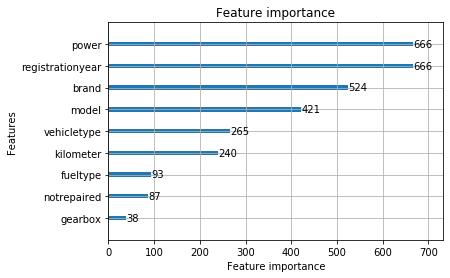

In [55]:
plot_importance(boost_model, ignore_zero=False);

Как видно из графика, самые важные факторы - мощность автомобиля и год его выпуска. Самые незначительные - тип топлива, ремонт и коробка передач.

## Анализ моделей

Проанализируем результаты.

In [56]:
result #Время немного другое, потому что я перезапускал ноутбук

,RMSE,"Время 1й итерации, секунд","Время предсказания, секунд"
Заполнение средним,4669,0.00,0.00
Линейная регрессия,2595,24.90,0.13
Случайный лес,1833,287.00,0.70
LightGBM,1684,10.25,1.18


По итогу:
1. Заполнение средним показывает плохой результат, но зато выполняется мнгновенно :)
2. Линейная регрессия учится достаточно быстро. Результат её предсказания намного превосходит средний. Также плюсом является отсутствие необходимости перебирать параметры.
3. Случайный лес имеет большое преимущество по точности предсказания перед линейной регрессии. Но время 1й итерации является очень долгим. Чтобы первично подобрать параметры пришлось ждать около часа.
4. Лидером по точности предсказаний и времени 1й итерации является LightGBM. Перебор параметров занял не много времени, а обучение без перебора происходит быстрее, чем у линейной модели. Небольшим недостатком является самое больше время предсказания из всех обученных моделей.